# Running Multinomial Baysian Logistic Regression on GAP layer outputs

In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# to add parent dir to python path
import sys
sys.path.insert(0, '../..')
import multinomial_bayes_logistic as mbl

In [3]:
save_dir = Path("pretrained")

In [4]:
with open(save_dir / 'x_extract.pkl', 'rb') as f_x, open(save_dir / 'y_extract.pkl', 'rb') as f_y:
    # Pickle the 'data' dictionary using the highest protocol available.
    x_extract = pickle.load(f_x)
    y_extract = pickle.load(f_y)

In [5]:
# scale inputs
scaler = StandardScaler()
x_extract['train'] = scaler.fit_transform(x_extract['train'])
x_extract['val'] = scaler.transform(x_extract['val'])

In [6]:
for phase in x_extract:
    x_extract[phase] = np.c_[x_extract[phase], np.ones(len(x_extract[phase]))]

In [7]:
# set up prior
m_train = x_extract['train'].shape[0]
n_train = x_extract['train'].shape[1]

w_prior = np.zeros((10, n_train))
H_prior = np.eye(n_train*10) 

In [8]:
n_epoch = 1 # one epoch will do
batch_size = m_train # on all dataset at once

for epoch in range(n_epoch):
    ran_idx = np.random.permutation(np.arange(m_train))
    batch_idx = np.array_split(ran_idx, m_train//batch_size)
    for idx in batch_idx:
        w_prior, H_prior = mbl.fit(
            y_extract['train'][idx], x_extract['train'][idx], w_prior, H_prior, use_autograd=False)

/home/zl430/anaconda3/envs/pt-gpu/lib/python3.7/site-packages/autograd/tracer.py:48: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f_raw(*args, **kwargs)


In [9]:
# get bayes point
val_probs, val_preds, val_max_prob = mbl.get_bayes_point_probs(x_extract['val'], w_prior)
val_correct = np.sum(val_preds == (y_extract["val"]))
val_accuracy = val_correct/len(y_extract['val'])
print("Bayes Point, Epoch: {}, Val Acc: {:.1%}".format(epoch, val_accuracy))

Bayes Point, Epoch: 0, Val Acc: 94.3%


In [10]:
# get monte carlo
mc_val_probs, mc_val_preds, mc_val_max_prob = mbl.get_monte_carlo_probs(x_extract['val'], w_prior, H_prior)
mc_val_correct = np.sum(mc_val_preds == (y_extract["val"]))
mc_val_accuracy = mc_val_correct/len(y_extract['val'])
print("Monte Carlo, Epoch: {}, Val Acc: {:.1%}".format(epoch, mc_val_accuracy))

Monte Carlo, Epoch: 0, Val Acc: 94.3%


In [11]:
mean_increase_in_uncertainty = (np.mean(val_max_prob[val_preds == y_extract["val"]]) 
                                - np.mean(mc_val_max_prob[mc_val_preds == y_extract["val"]]))*100
print("For true positives, increase in uncertainty given by monte carlo over bayes point is {}%".format(mean_increase_in_uncertainty))

For true positives, increase in uncertainty given by monte carlo over bayes point is 0.04595581727503406%


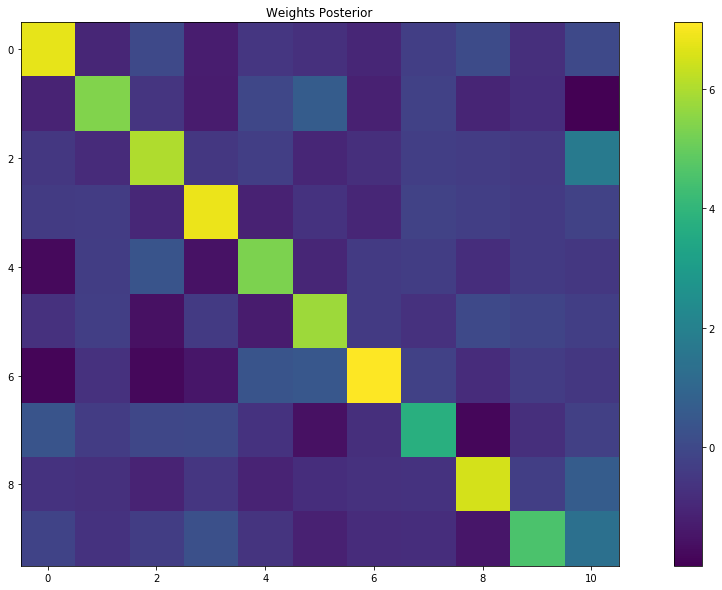

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(w_prior)
plt.title("Weights Posterior")
plt.colorbar()

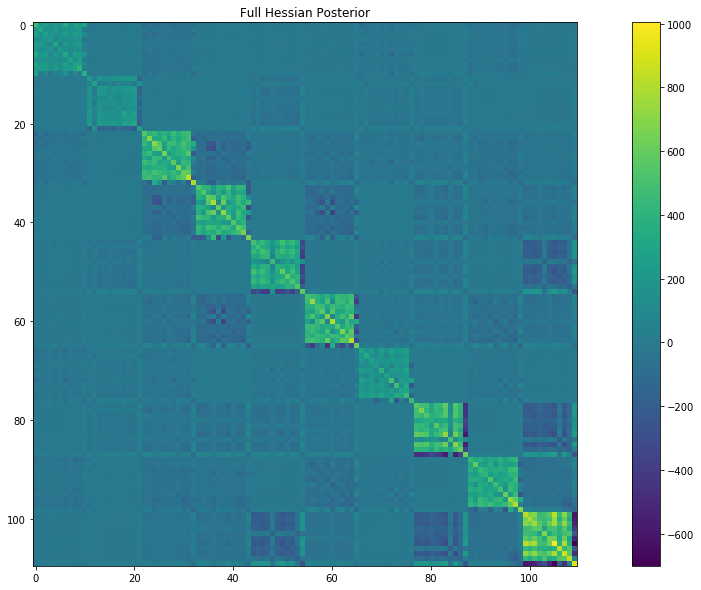

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(H_prior)
plt.title("Full Hessian Posterior")
plt.colorbar()

# Graph the decision boundary

In [14]:
m_train = x_extract['train'].shape[0]
n_train = x_extract['train'].shape[1]

In [15]:
batch_sizes = (100, 500, 1000, m_train)# train using less examples to get the curvature in contour
w_posterior = {}
h_posterior = {}
val_accuracies = {}

# predict using multinomial bayes logistic
    
for batch_size in batch_sizes:
    w_prior = np.zeros((10, n_train))
    H_prior = np.eye(n_train*10) 

    w_prior, H_prior = mbl.fit(
        np.int32(y_extract['train'][:batch_size]), x_extract['train'][:batch_size], w_prior, H_prior, use_autograd=False)
    
    val_probs, val_preds, val_max_prob = mbl.get_bayes_point_probs(x_extract['val'], w_prior)
    val_correct = np.sum(val_preds == (y_extract["val"]))
    val_accuracy = val_correct/len(y_extract['val'])
    
    w_posterior[batch_size] = w_prior
    h_posterior[batch_size] = H_prior
    val_accuracies[batch_size] = val_accuracy

/home/zl430/anaconda3/envs/pt-gpu/lib/python3.7/site-packages/autograd/tracer.py:48: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f_raw(*args, **kwargs)


In [16]:
pca = PCA(n_components = 2)
pca.fit(x_extract['train'])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [17]:
V = pca.components_.T

In [18]:
def plot_decision_boundary(batch_sizes, inference):
    plt.figure(figsize=((len(batch_sizes) + 1)* 10, 10))
    
    for phase in ('train', 'val'):
        for col, batch_size in enumerate(batch_sizes):
            if phase == 'val':
                col = len(batch_sizes)
                batch_size = len(x_extract['train'])
            plt.subplot(1, len(batch_sizes) + 1, col + 1)
            
            # plotting the data points
            X = pca.transform(x_extract[phase])
            Y = y_extract[phase]
            
            for digit in range(0, 10):
                plt.scatter(X[Y==digit, 0], X[Y==digit, 1], alpha=0.1, c='0.9')

            X = X[:batch_size]
            Y = Y[:batch_size]
            
            for digit in range(0, 10):
                plt.scatter(X[Y==digit, 0], X[Y==digit, 1], label='Digit {}'.format(digit))

            # plotting the contours  
            min_x = np.min(X[:, 0])
            max_x = np.max(X[:, 0])

            min_y = np.min(X[:, 1])
            max_y = np.max(X[:, 1])

            xx, yy = np.mgrid[min_x - .5 * max_x: max_x + .5 * max_x:50j, min_y - .5 * max_y: max_y + .5 * max_y:50j]
            coords = np.c_[xx.ravel(), yy.ravel()] @ V.T

            if inference == 'monte carlo':
                *_, probs = mbl.get_monte_carlo_probs(coords, w_posterior[batch_size], h_posterior[batch_size])
            elif inference == 'bayes point':
                *_, probs = mbl.get_bayes_point_probs(coords, w_posterior[batch_size])
            zz = probs.reshape(xx.shape)

            contours = plt.contour(xx, yy, zz, 5)
            plt.clabel(contours, fontsize=24)

            plt.legend(loc="upper right", fontsize=24)
            if phase == 'val':
                plt.title('Val dataset', fontsize=28)
            else:
                plt.title("{}, acc {:.1%}, n={}".format(phase.capitalize(), val_accuracies[batch_size], batch_size), fontsize=28)  
            if phase == 'val':
                break
                
    plt.suptitle('Using {} inference'.format(inference), fontsize=32)
    plt.show()

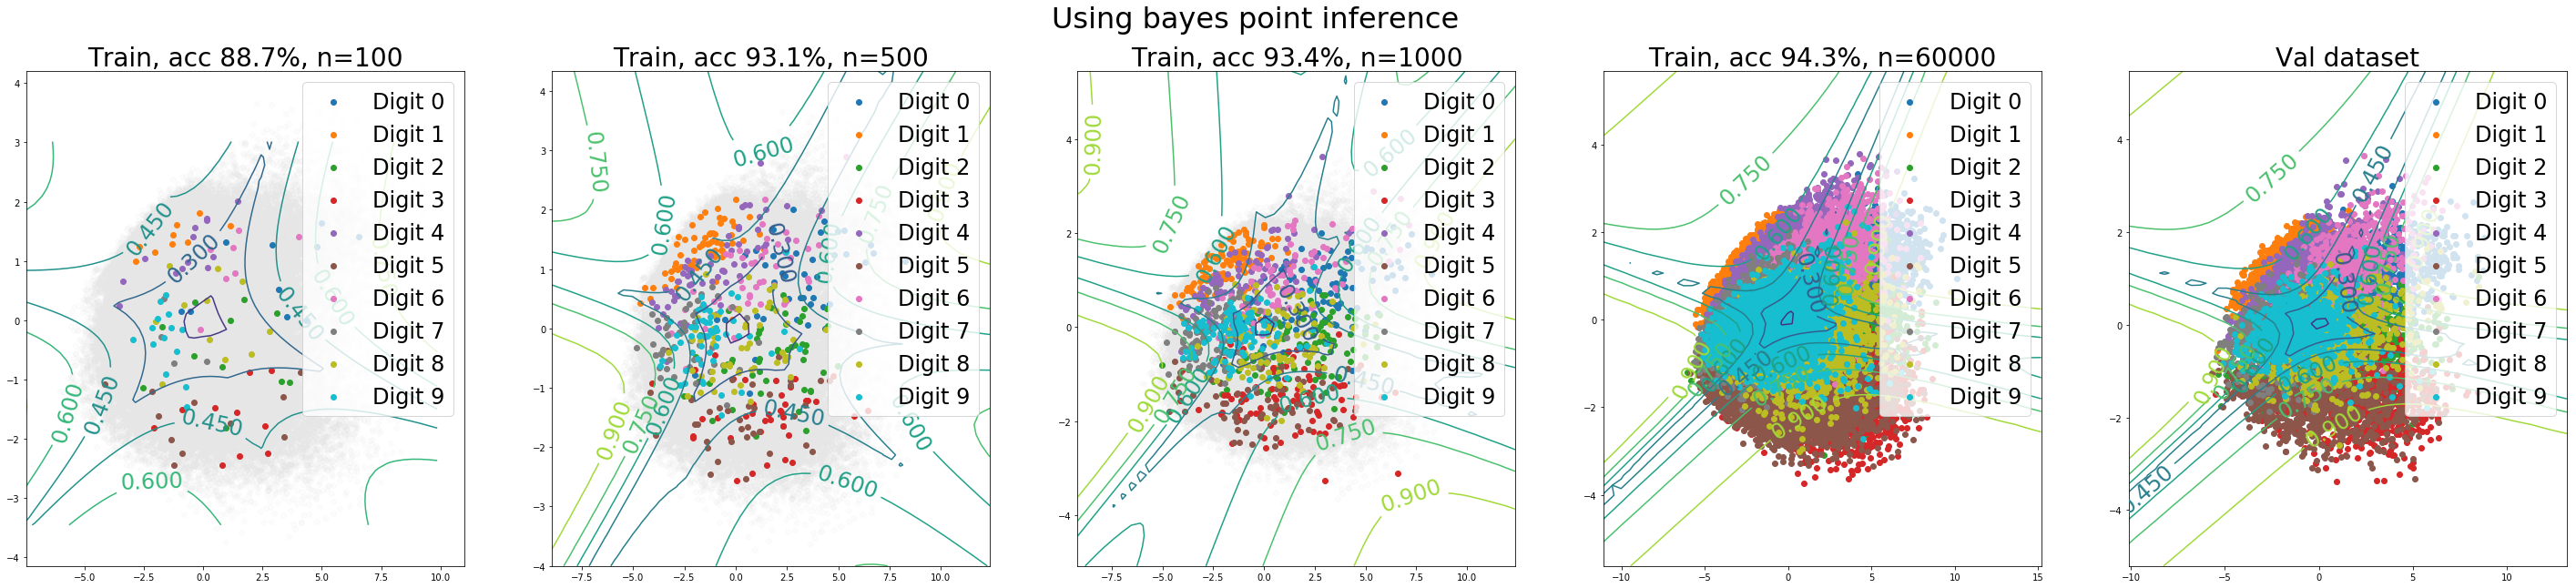

In [19]:
plot_decision_boundary(batch_sizes, 'bayes point')

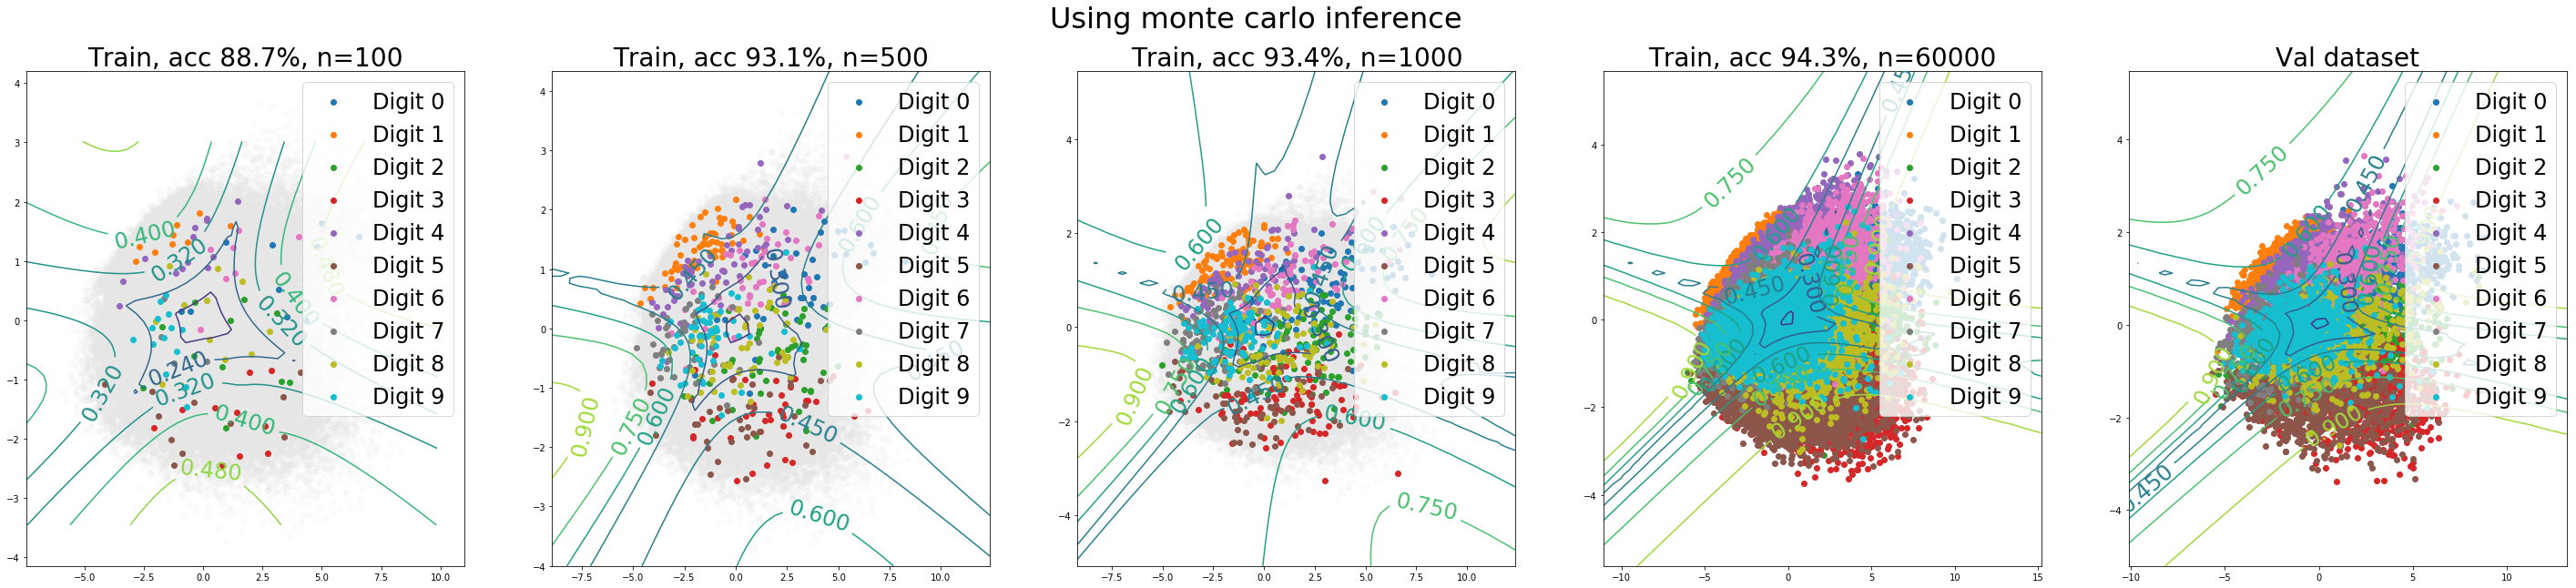

In [20]:
plot_decision_boundary(batch_sizes, 'monte carlo')